# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We are now ready to work through 
a fully functioning implementation 
of linear regression. 
In this section, 
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function 
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset. 
While modern deep learning frameworks 
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it is time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only 
on tensors and automatic differentiation.
Later, we will introduce a more concise implementation,
taking advantage of the bells and whistles of deep learning frameworks 
while retaining the structure of what follows below.


In [87]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
import optax
from flax import nnx

tfd = tfp.distributions
key = tfp.util.SeedStream(2024, salt="regression")

In [88]:
eval_every = 100
batch_size = 250

In [89]:
# generate synthetic regression data
def gen_reg_data(w, b, seed, noise=0.01, n=500):
	key = tfp.util.SeedStream(seed, salt="gen_reg_data")
	normal = tfd.Normal(loc=0.0, scale=1.0)
	X = normal.sample((n, w.shape[0]), seed=key())
	noise = normal.sample((n, 1), seed=key()) * noise
	return X, jnp.matmul(X, jnp.reshape(w, (-1, 1))) + b + noise

In [90]:
# checking...
from sklearn.linear_model import LinearRegression

xx, yy = gen_reg_data(w=jnp.array([2, 3.4]), b=4.2, n=500, seed=714)

reg = LinearRegression()
reg1 = reg.fit(xx, yy)
reg1.coef_, reg1.intercept_

(array([[2.0007281, 3.4003763]], dtype=float32),
 array([4.199874], dtype=float32))

In [91]:
train_data = gen_reg_data(w=jnp.array([2, 3.4]), b=4.2, n=500, seed=714)
train_data = tf.data.Dataset.from_tensor_slices(train_data).repeat(1000).shuffle(200)
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

In [92]:
tf.data.experimental.cardinality(train_data)

<tf.Tensor: shape=(), dtype=int64, numpy=2000>

In [93]:
test_data = gen_reg_data(w=jnp.array([2, 3.4]), b=4.2, n=250, seed=714)
test_data = tf.data.Dataset.from_tensor_slices(test_data)
test_data = test_data.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

## Defining the Model

In [94]:
class LinearRegression(nnx.Module):
	def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):
		key = rngs.params()
		self.w = nnx.Param(jax.random.uniform(key, (din, dout)))
		self.b = nnx.Param(jnp.zeros((dout,)))
		self.din, self.dout = din, dout
	
	def __call__(self, x: jax.Array):
		return x @ self.w + self.b

In [95]:
model = LinearRegression(din=2, dout=1, rngs=nnx.Rngs(params=0))

In [96]:
y = model(x=jnp.ones((3, 2)))
y

Array([[0.8078517],
       [0.8078517],
       [0.8078517]], dtype=float32)

In [97]:
nnx.display(model)

LinearRegression(
  w=Param(
    value=Array(shape=(2, 1), dtype=float32)
  ),
  b=Param(
    value=Array([0.], dtype=float32)
  ),
  din=2,
  dout=1
)


## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`. 
We also return the averaged loss value
among all examples in the minibatch.


In [98]:
def loss_fn(model, batch):
  x, y = batch
  y_hat = model(x)
  loss = optax.l2_loss(predictions=y_hat, targets=y).mean()
  return loss, y_hat

## Defining the Optimization Algorithm

In [99]:
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.005))
nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=LinearRegression(
    w=Param(
      value=Array(shape=(2, 1), dtype=float32)
    ),
    b=Param(
      value=Array([0.], dtype=float32)
    ),
    din=2,
    dout=1
  ),
  tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x34942d120>, update=<function chain.<locals>.update_fn at 0x34942d080>),
  opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=State({
    'b': VariableState(
      type=Param,
      value=Array([0.], dtype=float32)
    ),
    'w': VariableState(
      type=Param,
      value=Array(shape=(2, 1), dtype=float32)
    )
  }), nu=State({
    'b': VariableState(
      type=Param,
      value=Array([0.], dtype=float32)
    ),
    'w': VariableState(
      type=Param,
      value=Array(shape=(2, 1), dtype=float32)
    )
  })), EmptyState()),
  wrt=<class 'flax.nnx.nnx.variables.Param'>
)


In [100]:
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'))

## Training

In [101]:
@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, y_hat), grads = grad_fn(model, batch)
  metrics.update(loss=loss)
  optimizer.update(grads)

In [102]:
@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch):
  loss, _ = loss_fn(model, batch)
  metrics.update(loss=loss)

In [103]:
metrics_history = {
  'train_loss': [],
  'test_loss': [],
}

for step, batch in enumerate(train_data.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)
  
	# One training epoch has passed.
  if step > 0 and (step % eval_every == 0): 
    # Log the training metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'train_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_data.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

2024-10-14 07:55:51.558431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 07:55:51.620116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 07:55:51.678434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 07:55:51.734739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 07:55:51.792298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 07:55:51.849151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 07:55:51.909937: W tensorflow/core/framework/local_rendezvous.cc:404] L

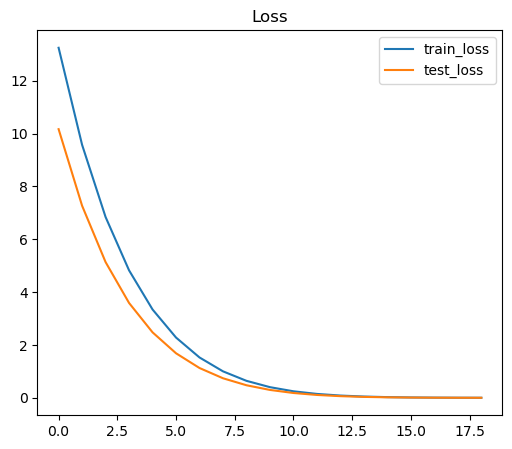

In [104]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title('Loss')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
ax1.legend()
plt.show()

In [105]:
# w=[2, 3.4], b=4.2
model.w, model.b

(Param(
   value=Array([[2.0001075],
          [3.4033806]], dtype=float32)
 ),
 Param(
   value=Array([4.1711726], dtype=float32)
 ))

We should not take the ability to exactly recover 
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature 
is linearly dependent on the others.
However, in machine learning, 
we are often less concerned
with recovering true underlying parameters,
but rather with parameters 
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step 
towards designing deep learning systems 
by implementing a fully functional 
neural network model and training loop.
In this process, we built a data loader, 
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool. 
We did this by composing a Python object 
that contains all relevant components for training a model. 
While this is not yet a professional-grade implementation
it is perfectly functional and code like this 
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).



## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistance that relates voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.
1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. Why is the `reshape` method needed in the `loss` function?
1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?
1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?


[Discussions](https://discuss.d2l.ai/t/17976)
